In [32]:
!conda install -c conda-forge -y mplsoccer

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - mplsoccer


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mplsoccer-1.2.2            |     pyhd8ed1ab_0          67 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          67 KB

The following NEW packages will be INSTALLED:

  mplsoccer          conda-forge/noarch::mplsoccer-1.2.2-pyhd8ed1ab_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontManager
from matplotlib.colors import to_rgba
from mplsoccer import Pitch

In [2]:
with open("./data/WhoScored/match_1734731.json") as f:
    data_dict = json.load(f)
data_dict.keys()

dict_keys(['matchId', 'matchCentreData', 'matchCentreEventTypeJson', 'formationIdNameMappings'])

In [3]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

In [4]:
events_dict, players_df, teams_dict = extract_data_from_dict(data_dict)
len(events_dict)

1638

In [5]:
teams_dict

{65: 'Barcelona', 2783: 'Girona'}

In [6]:
home_team_id = 2783
away_team_id = 65
# home_team_id, away_team_id

In [7]:
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes

In [8]:
passes_df = get_passes_df(events_dict)
passes_df

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.627665e+09,49.8,50.1,35.6,28.4,65,402197.0,301019.0,Pass,Successful
3,2.627665e+09,35.6,28.4,72.0,58.7,65,301019.0,29400.0,Pass,Successful
6,2.627665e+09,73.8,58.1,91.8,60.0,65,29400.0,104732.0,Pass,Unsuccessful
8,2.627665e+09,13.5,35.3,26.5,22.4,2783,104732.0,372473.0,Pass,Successful
9,2.627665e+09,26.5,22.4,30.3,6.3,2783,372473.0,421975.0,Pass,Successful
...,...,...,...,...,...,...,...,...,...,...
1603,2.627708e+09,80.1,72.8,79.8,62.4,65,422938.0,445345.0,Pass,Unsuccessful
1606,2.627708e+09,9.5,83.6,12.8,81.5,2783,395788.0,480249.0,Pass,Unsuccessful
1620,2.627709e+09,99.6,0.4,88.0,14.6,65,480249.0,279423.0,Pass,Successful
1621,2.627709e+09,86.8,18.6,91.3,48.7,65,279423.0,24400.0,Pass,Unsuccessful


In [9]:
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    print(team_id)
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    # print(average_locs_and_count_df)

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df

In [10]:
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(team_id=home_team_id, passes_df=passes_df, players_df=players_df)
home_passes_between_df

2783


,pos_min,pos_max,pass_count,x,y,count,name,shirtNo,position,x_end,y_end,count_end,name_end,shirtNo_end,position_end
5,70033.0,92691.0,10,40.765000,80.163333,60,Daley Blind,17,DC,28.950000,52.847222,36,David López,5,DC
6,70033.0,104732.0,6,40.765000,80.163333,60,Daley Blind,17,DC,11.065909,42.654545,44,Paulo Gazzaniga,13,GK
8,70033.0,231125.0,7,40.765000,80.163333,60,Daley Blind,17,DC,55.165625,39.390625,32,Viktor Tsygankov,8,AMC
9,70033.0,280663.0,24,40.765000,80.163333,60,Daley Blind,17,DC,47.972973,58.371622,74,Aleix García,14,MC
10,70033.0,296975.0,4,40.765000,80.163333,60,Daley Blind,17,DC,52.895238,51.328571,21,Artem Dovbyk,9,FW
14,70033.0,368091.0,2,40.765000,80.163333,60,Daley Blind,17,DC,36.767500,19.115000,40,Eric García,25,DC
15,70033.0,372473.0,12,40.765000,80.163333,60,Daley Blind,17,DC,46.355102,45.373469,49,Iván Martín,23,MC
16,70033.0,395788.0,21,40.765000,80.163333,60,Daley Blind,17,DC,50.288462,81.575000,52,Miguel Gutiérrez,3,DML
17,70033.0,397821.0,15,40.765000,80.163333,60,Daley Blind,17,DC,72.429032,83.970968,31,Sávio,16,AMC
19,70033.0,421975.0,1,40.765000,80.163333,60,Daley Blind,17,DC,44.634091,15.740909,44,Yan Couto,20,DMR


In [11]:
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(team_id=away_team_id, passes_df=passes_df, players_df=players_df)
away_passes_between_df

65


,pos_min,pos_max,pass_count,x,y,count,name,shirtNo,position,x_end,y_end,count_end,name_end,shirtNo_end,position_end
2,29400.0,77464.0,2,74.728571,48.585714,14,Robert Lewandowski,9,FW,53.650000,52.645238,84,Ilkay Gündogan,22,MC
5,29400.0,128967.0,2,74.728571,48.585714,14,Robert Lewandowski,9,FW,54.862712,82.579661,59,João Cancelo,2,DL
6,29400.0,130331.0,2,74.728571,48.585714,14,Robert Lewandowski,9,FW,43.371429,70.136735,49,Andreas Christensen,15,DC
7,29400.0,279423.0,5,74.728571,48.585714,14,Robert Lewandowski,9,FW,55.828571,46.734524,84,Frenkie de Jong,21,MC
8,29400.0,300447.0,4,74.728571,48.585714,14,Robert Lewandowski,9,FW,68.476667,16.430000,30,Raphinha,11,FWR
9,29400.0,301019.0,4,74.728571,48.585714,14,Robert Lewandowski,9,FW,50.176667,13.346667,60,Jules Koundé,23,DR
10,29400.0,362431.0,3,74.728571,48.585714,14,Robert Lewandowski,9,FW,67.795238,62.785714,21,João Félix,14,FWL
12,29400.0,402197.0,8,74.728571,48.585714,14,Robert Lewandowski,9,FW,61.102083,34.091667,48,Pedri,8,MC
26,77464.0,128967.0,13,53.650000,52.645238,84,Ilkay Gündogan,22,MC,54.862712,82.579661,59,João Cancelo,2,DL
27,77464.0,130331.0,27,53.650000,52.645238,84,Ilkay Gündogan,22,MC,43.371429,70.136735,49,Andreas Christensen,15,DC


In [12]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size, marker='h',
                               color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        print(row)
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='#C4C4C4', va='center',
                       ha='center', size=14, ax=ax)

    return pitch

x                   40.765
y                80.163333
count                   60
name           Daley Blind
shirtNo                 17
position                DC
marker_size    2432.432432
Name: 70033.0, dtype: object
x                    28.95
y                52.847222
count                   36
name           David López
shirtNo                  5
position                DC
marker_size    1459.459459
Name: 92691.0, dtype: object
x                    11.065909
y                    42.654545
count                       44
name           Paulo Gazzaniga
shirtNo                     13
position                    GK
marker_size        1783.783784
Name: 104732.0, dtype: object
x                     55.165625
y                     39.390625
count                        32
name           Viktor Tsygankov
shirtNo                       8
position                    AMC
marker_size         1297.297297
Name: 231125.0, dtype: object
x                 47.972973
y                 58.371622
count  

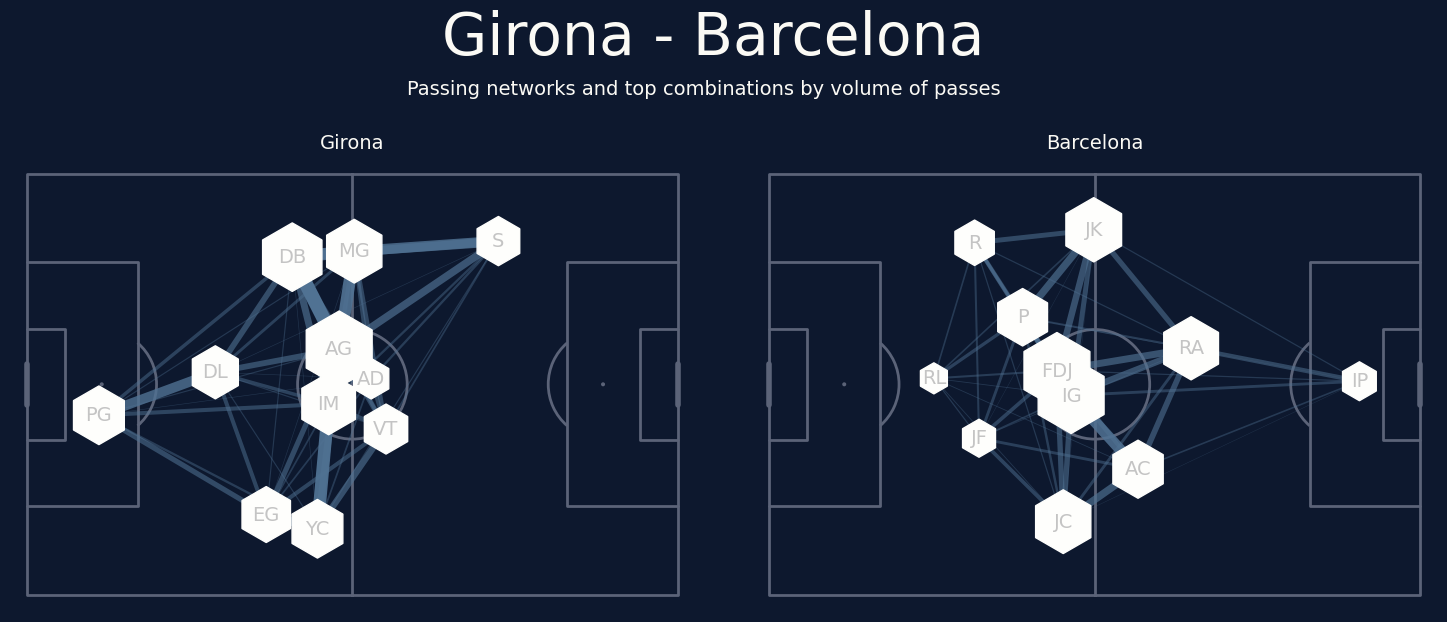

In [13]:
# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#0D182E")

# plot variables
main_color = '#FBFAF5'
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "RobotoCondensed-Medium.ttf?raw=true"))

# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)#, fontproperties=font_bold.prop)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14)#, fontproperties=font_bold.prop)

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)#, fontproperties=font_bold.prop)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)#, fontproperties=font_bold.prop)
plt.show()